In [0]:
import random
import numpy as np
import pickle

In [2]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time


In [0]:
ROOT = '/content/drive/My Drive/19 Fall/CSE 569/Project'

In [8]:
_X_val = []
_y_val = []
for i in range(10):
  _X_val.append(pickle.load(open(ROOT + '/cifar/labeled/X_test_label' + str(i), mode='rb')))
  _y_val.append(pickle.load(open(ROOT + '/cifar/labeled/y_test_label' + str(i), mode='rb')))

X_val = np.vstack(_X_val)
y_val = np.vstack(_y_val)

print(X_val.shape, y_val.shape)

(10000, 32, 32, 3) (10000, 10)


In [0]:
# Functions for plots
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2,figsize=(10, 5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history['accuracy'])+1),model_history['accuracy'])
    axs[0].plot(range(1,len(model_history['val_accuracy'])+1),model_history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history['accuracy'])+1),len(model_history['accuracy'])/10)
    axs[0].legend(['train', 'validation'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history['loss'])+1),model_history['loss'])
    axs[1].plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
    axs[1].legend(['train', 'validation'], loc='best')
    plt.show()

In [0]:
def get_class_label(one_hot):
  max_class_label = 0
  for class_label in range(1, len(one_hot)):
    max_class_label = max(
      (one_hot[max_class_label], max_class_label), (one_hot[class_label], class_label),
      key=lambda a: a[0]
    )[1]
  return max_class_label


def get_confusion_matrix(model, X_val, y_val):
  confusion = {class_num: np.zeros((10, 10)) for class_num in range(10)}
  for class_num in range(10):
    # get validation samples and their expected results
    class_start_row = class_num * 1000
    class_end_row = (class_num + 1) * 1000
    X_val_class = X_val[class_start_row:class_end_row, :]
    y_val_class = y_val[class_start_row:class_end_row, :]
    assert X_val_class.shape == (1000, 32, 32, 3)
    assert y_val_class.shape == (1000, 10)

    # get predicted results of the validation samples from the CNN
    batch_size = 100
    steps = 1000 // batch_size
    y_pred_class = model.predict(X_val_class, batch_size=batch_size, verbose=0, steps=steps)
    assert y_pred_class.shape == (1000, 10)

    # generate the confusion matrix of the expected and predicted results
    # of the validation samples for the current class
    for sample in range(1000):
      exp_class = get_class_label(y_val_class[sample])
      pred_class = get_class_label(y_pred_class[sample])
      assert exp_class >= 0 and exp_class < 10
      assert pred_class >= 0 and pred_class < 10
      confusion[class_num][pred_class, exp_class] += 1
    

  # concatenate the confusion matrices of each class into a single matrix
  confusion_matrix = np.zeros((10, 10))
  for class_num in confusion.keys():
    for row in range(confusion[class_num].shape[0]):
      for col in range(confusion[class_num].shape[1]):
        confusion_matrix[row, col] += confusion[class_num][row, col]
  return confusion_matrix

def get_metrics(confusion):
  true_positive = np.zeros(10)
  for i in range(10):
    true_positive[i] = confusion[i][i]
  s = np.sum(confusion, axis=0)
  false_positive = np.zeros(10)
  for i in range(10):
    false_positive[i] = s[i] - true_positive[i]
  s = np.sum(confusion, axis=1)
  false_negative = np.zeros(10)
  for i in range(10):
    false_negative[i] = s[i] - true_positive[i]
  s = np.sum(np.sum(confusion, axis=1))
  true_negative = np.zeros(10)
  for i in range(10):
    true_negative[i] = s - true_positive[i] - false_positive[i] - false_negative[i]
  accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
  recall = (true_positive)/(true_positive + false_negative)
  precision = (true_positive)/(true_positive + false_positive)
  f1 = (2 * precision * recall)/(precision + recall)
  return accuracy, recall, precision, f1

In [0]:
def plot_metrics_and_graph(path, custom_objects):
  model = tensorflow.keras.models.load_model(path + "model.h5", custom_objects=custom_objects)
  confusion = get_confusion_matrix(model, X_val, y_val)
  print(confusion)
  accuracy, recall, precision, f1 = get_metrics(confusion)
  print('accuracy', accuracy)
  print('recall', recall)
  print('precision', precision)
  print('f1', f1)
  fit_history = pickle.load(open(path + "fit_history", 'rb'))
  plot_model_history(fit_history)

In [0]:
def custom_loss(Y, A):
  P = tensorflow.keras.backend.max(Y, axis=1)
  # P = tensorflow.keras.backend.print_tensor(P, message="P is: ")

  # Labeled encodings will have max = 1
  Y_l = tensorflow.boolean_mask(Y, tensorflow.equal(P, 1))
  A_l = tensorflow.boolean_mask(A, tensorflow.equal(P, 1))
  # Y_l = tensorflow.keras.backend.print_tensor(Y_l, message="Y_l is: ")
  # A_l = tensorflow.keras.backend.print_tensor(A_l, message="A_l is: ")
  A_l_log = tensorflow.keras.backend.log(A_l)
  A_l = tensorflow.keras.backend.flatten(A_l)
  A_l_log = tensorflow.keras.backend.flatten(A_l_log)
  A_l_log = tensorflow.keras.backend.abs(A_l_log)
  Y_l = tensorflow.keras.backend.flatten(Y_l)

  # Y_l = tensorflow.keras.backend.print_tensor(Y_l, message="Y_l flattened is: ")
  # A_l_log = tensorflow.keras.backend.print_tensor(A_l_log, message="A_l_log flattened is: ")

  L_l = A_l_log * Y_l
  L_l = tensorflow.boolean_mask(L_l, tensorflow.greater(L_l, 0))
  L_l = tensorflow.keras.backend.mean(L_l)
  # L_l = tensorflow.keras.backend.print_tensor(L_l, message="L_l is: ")

  # Unlabeled encodings will have max less than 1
  Y_u = tensorflow.boolean_mask(Y, tensorflow.less(P, 1))
  A_u = tensorflow.boolean_mask(A, tensorflow.less(P, 1))
  # Y_u = tensorflow.keras.backend.print_tensor(Y_u, message="Y_u is: ")
  # A_u = tensorflow.keras.backend.print_tensor(A_u, message="A_u is: ")
  A_u_log = tensorflow.keras.backend.log(A_u)
  # A_u_log = tensorflow.keras.backend.print_tensor(A_u_log, message="A_u_log is: ")
  A_u = tensorflow.keras.backend.flatten(A_u)
  A_u_log = tensorflow.keras.backend.flatten(A_u_log)
  A_u_log = tensorflow.keras.backend.abs(A_u_log)
  L_u = A_u * A_u_log
  L_u = tensorflow.keras.backend.mean(L_u)
  # L_u = tensorflow.keras.backend.print_tensor(L_u, message="L_u is: ")

  # L = 0 - L_l - L_u
  L = L_l + L_u
  # L = tensorflow.keras.backend.print_tensor(L, message="L is: ")
  # first param is loss during training which includes unlabeled samples and won't throw nan
  # second param is loss during validation which only has labeled samples so returning only labeled error to avoid nan
  return tensorflow.keras.backend.in_train_phase(L/1, L_l/1)


[[816.  15.  56.  10.   2.   8.   2.  13.  59.  21.]
 [ 12. 882.   2.   3.   1.   1.   0.   1.  15.  40.]
 [ 24.   2. 636.  38.  17.  19.  21.  14.   7.   2.]
 [ 22.   5.  33. 609.  28.  94.  24.  28.   9.   9.]
 [ 32.   3.  92.  66. 843.  48.  14.  80.   6.   6.]
 [  8.   2.  68. 173.  22. 781.  11.  52.   8.   4.]
 [ 15.   4.  98.  72.  61.  20. 920.  13.   7.   7.]
 [  6.   2.  12.  18.  21.  25.   4. 797.   3.   4.]
 [ 37.   8.   2.   5.   4.   0.   3.   1. 876.  12.]
 [ 28.  77.   1.   6.   1.   4.   1.   1.  10. 895.]]
accuracy [0.963  0.9807 0.9492 0.9357 0.9496 0.9433 0.9623 0.9702 0.9804 0.9766]
recall [0.81437126 0.92163009 0.81538462 0.70731707 0.70840336 0.69176262
 0.75595727 0.89349776 0.92405063 0.87402344]
precision [0.816 0.882 0.636 0.609 0.843 0.781 0.92  0.797 0.876 0.895]
f1 [0.81518482 0.90137966 0.71460674 0.65448684 0.76986301 0.73367778
 0.82995038 0.84249471 0.89938398 0.88438735]


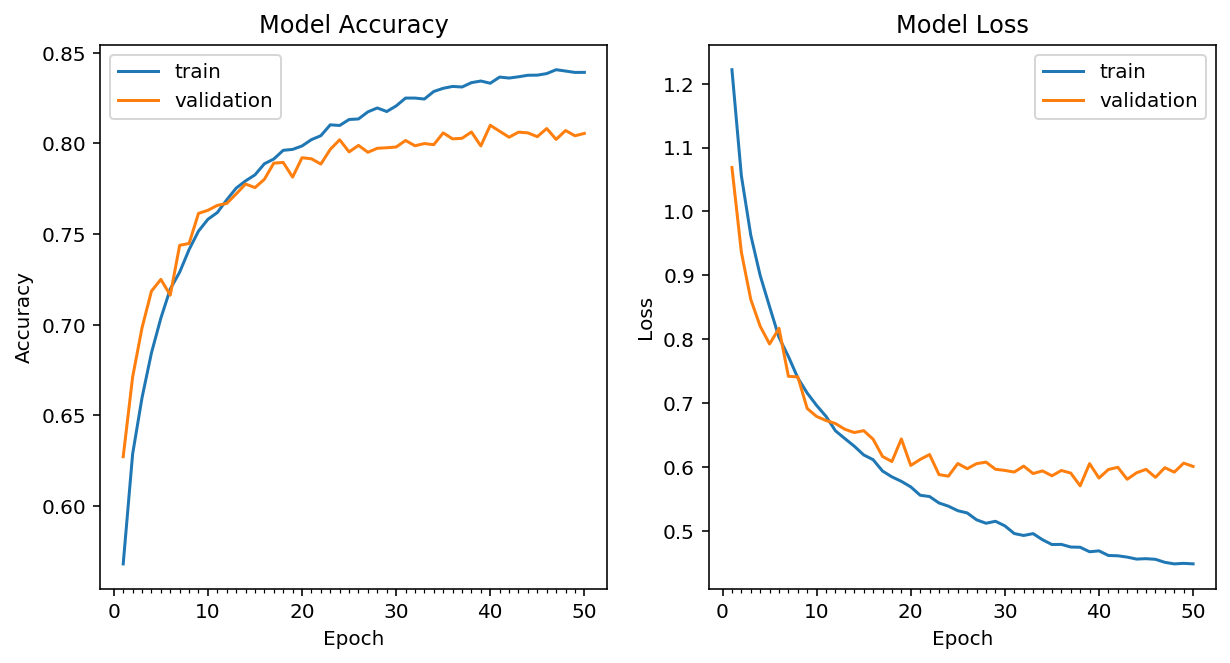

In [13]:
pctg_unlabeled=0
plot_metrics_and_graph(f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/baseline/", None)

# 25% Unlabeled Entropy

[[821.   8.  57.  19.   8.  10.   4.  15.  55.  20.]
 [ 13. 868.   1.   2.   1.   2.   0.   2.  10.  44.]
 [ 50.   3. 705.  58.  64.  45.  32.  45.   9.   4.]
 [ 17.   5.  40. 671.  50. 213.  45.  54.  12.  12.]
 [ 12.   2.  62.  51. 778.  38.  16.  47.   5.   2.]
 [  0.   3.  38.  88.  14. 630.   6.  39.   1.   0.]
 [  7.   7.  68.  75.  56.  28. 889.   9.  10.   8.]
 [  6.   2.  15.  17.  19.  27.   3. 777.   3.   5.]
 [ 48.  16.   8.   7.   8.   3.   3.   4. 872.  21.]
 [ 26.  86.   6.  12.   2.   4.   2.   8.  23. 884.]]
accuracy [0.9625 0.9793 0.9395 0.9223 0.9543 0.9441 0.9621 0.968  0.9754 0.9715]
recall [0.8072763  0.9204666  0.69458128 0.59964254 0.76801579 0.76923077
 0.76836646 0.88901602 0.88080808 0.83950617]
precision [0.821 0.868 0.705 0.671 0.778 0.63  0.889 0.777 0.872 0.884]
f1 [0.81408032 0.89346372 0.69975186 0.6333176  0.77297566 0.69268829
 0.824293   0.82924226 0.87638191 0.86117876]


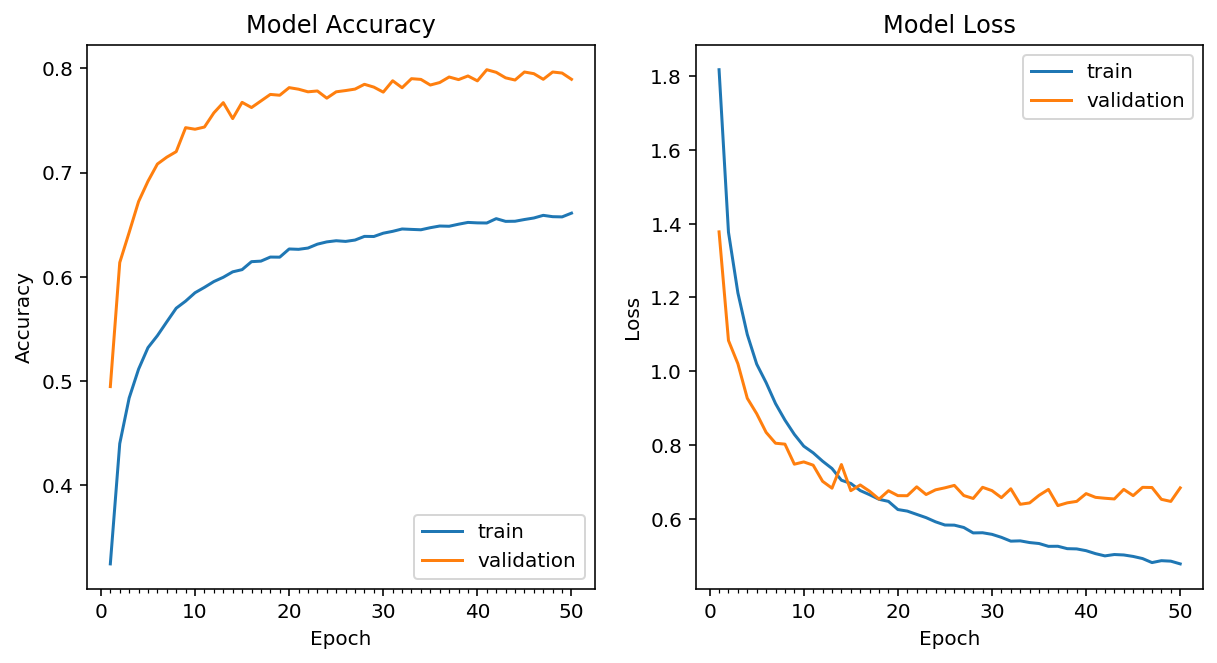

In [14]:
pctg_unlabeled=25
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/entropy/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})

# 50% Unlabeled Entropy

[[776.  11.  71.  23.  16.   8.   7.  14.  45.  17.]
 [ 21. 906.   5.  11.   2.   4.   2.   3.  31.  80.]
 [ 52.   5. 591.  50.  35.  42.  28.  22.   8.   4.]
 [ 10.   4.  41. 513.  43. 118.  25.  17.   6.   9.]
 [ 25.   1. 105.  80. 770.  57.  30.  50.   5.   7.]
 [  5.   1.  57. 177.  24. 687.   9.  52.   3.   2.]
 [ 11.   3.  84.  84.  50.  25. 889.   6.   5.   3.]
 [ 12.   5.  30.  35.  50.  49.   3. 821.   8.   8.]
 [ 56.  10.   7.  11.   9.   4.   5.   2. 870.  23.]
 [ 32.  54.   9.  16.   1.   6.   2.  13.  19. 847.]]
accuracy [0.9564 0.9747 0.9345 0.924  0.941  0.9357 0.9618 0.9621 0.9743 0.9695]
recall [0.7854251  0.85070423 0.70609319 0.65267176 0.68141593 0.67551622
 0.76637931 0.80411361 0.87261785 0.84784785]
precision [0.776 0.906 0.591 0.513 0.77  0.687 0.889 0.821 0.87  0.847]
f1 [0.7806841  0.87748184 0.64344039 0.57446809 0.72300469 0.68120972
 0.82314815 0.81246907 0.87130696 0.84742371]


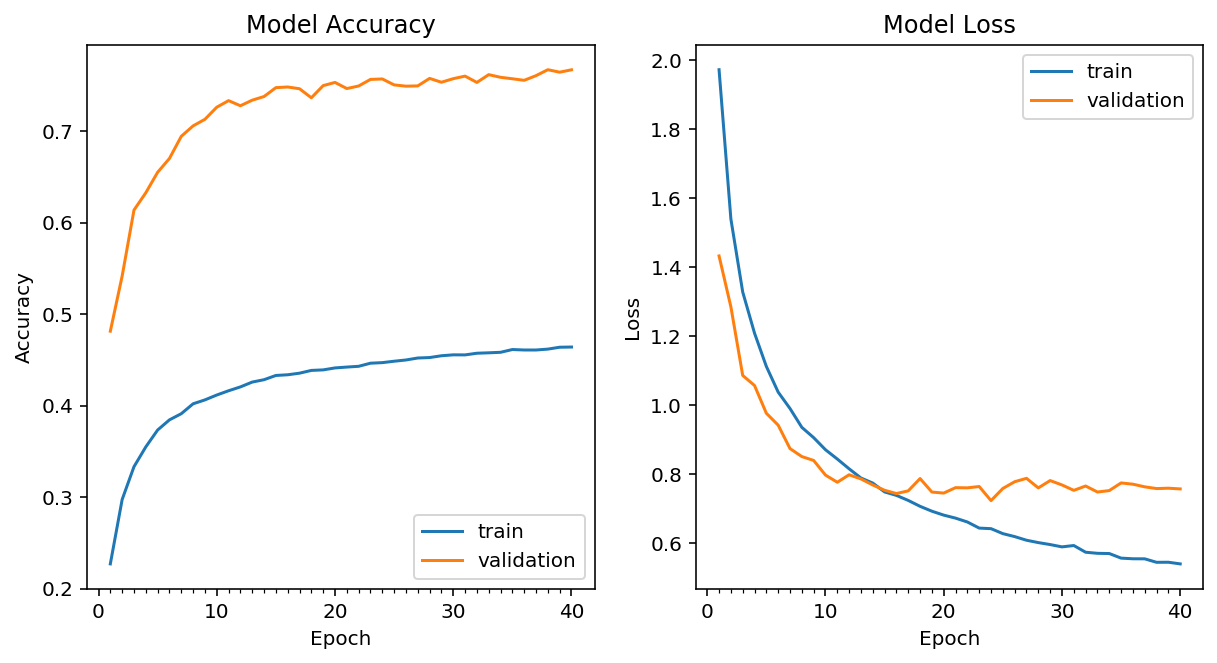

In [15]:
pctg_unlabeled=50
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/entropy/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})

# 75% Unlabeled Entropy

[[780.  18.  85.  24.  25.  16.   3.  22.  81.  36.]
 [ 19. 840.   4.   6.   4.   3.   1.   0.  23.  83.]
 [ 46.   7. 538.  50.  56.  32.  26.  37.  15.   8.]
 [ 29.   6.  74. 496.  53. 178.  51.  57.  15.  19.]
 [ 14.   6.  83.  52. 634.  40.  19.  67.   3.   6.]
 [  8.   9.  88. 231.  61. 668.  30.  96.  11.  17.]
 [ 11.  12.  96.  97. 105.  27. 858.  14.   9.  11.]
 [  9.   4.  19.  24.  55.  31.   5. 692.   7.  15.]
 [ 54.  17.   9.  13.   7.   2.   6.   4. 820.  19.]
 [ 30.  81.   4.   7.   0.   3.   1.  11.  16. 786.]]
accuracy [0.947  0.9697 0.9261 0.9014 0.9344 0.9117 0.9476 0.9523 0.9689 0.9633]
recall [0.71559633 0.85452696 0.6601227  0.50715746 0.68614719 0.54799016
 0.69193548 0.80371661 0.86225026 0.8370607 ]
precision [0.78  0.84  0.538 0.496 0.634 0.668 0.858 0.692 0.82  0.786]
f1 [0.74641148 0.84720121 0.59283747 0.50151668 0.65904366 0.60207301
 0.76607143 0.74368619 0.84059457 0.81072718]


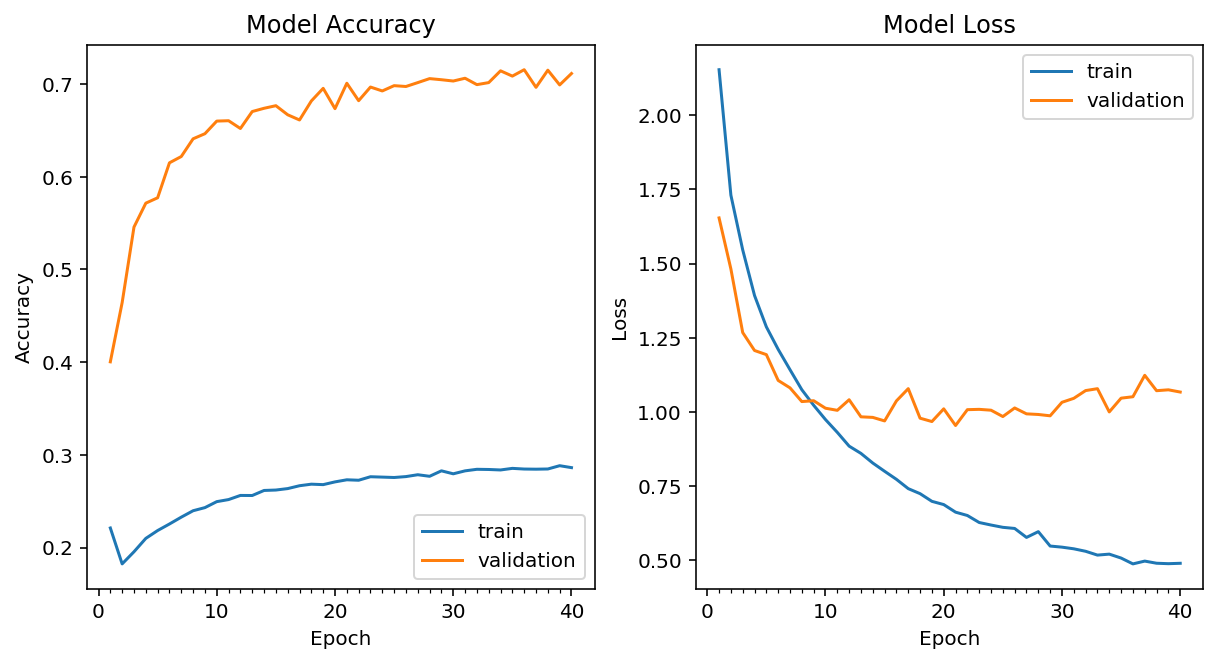

In [16]:
pctg_unlabeled=75
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/entropy/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})

# 25% Unlabeled Mixup

[[810.   5.  53.  11.   7.   4.   5.  10.  26.  13.]
 [ 12. 892.   6.   8.   3.   1.   2.   4.  16.  38.]
 [ 35.   3. 699.  60.  47.  36.  41.  35.   3.   5.]
 [  7.   4.  25. 603.  36. 130.  30.  27.   5.   9.]
 [ 16.   2.  84.  61. 815.  46.  28.  48.   2.   0.]
 [  2.   1.  42. 125.  16. 706.   3.  44.   3.   1.]
 [  7.   3.  59.  72.  35.  22. 874.   7.   5.   3.]
 [ 11.   0.  12.  23.  24.  36.   6. 807.   3.   2.]
 [ 68.  18.  14.  22.  16.   9.   7.   6. 925.  25.]
 [ 32.  72.   6.  15.   1.  10.   4.  12.  12. 904.]]
accuracy [0.9676 0.9802 0.9434 0.933  0.9528 0.9469 0.9661 0.969  0.974  0.974 ]
recall [0.85805085 0.90835031 0.72510373 0.68835616 0.73956443 0.74867444
 0.80404784 0.87337662 0.83333333 0.84644195]
precision [0.81  0.892 0.699 0.603 0.815 0.706 0.874 0.807 0.925 0.904]
f1 [0.83333333 0.90010091 0.71181263 0.64285714 0.77545195 0.72671127
 0.83756588 0.83887734 0.87677725 0.87427466]


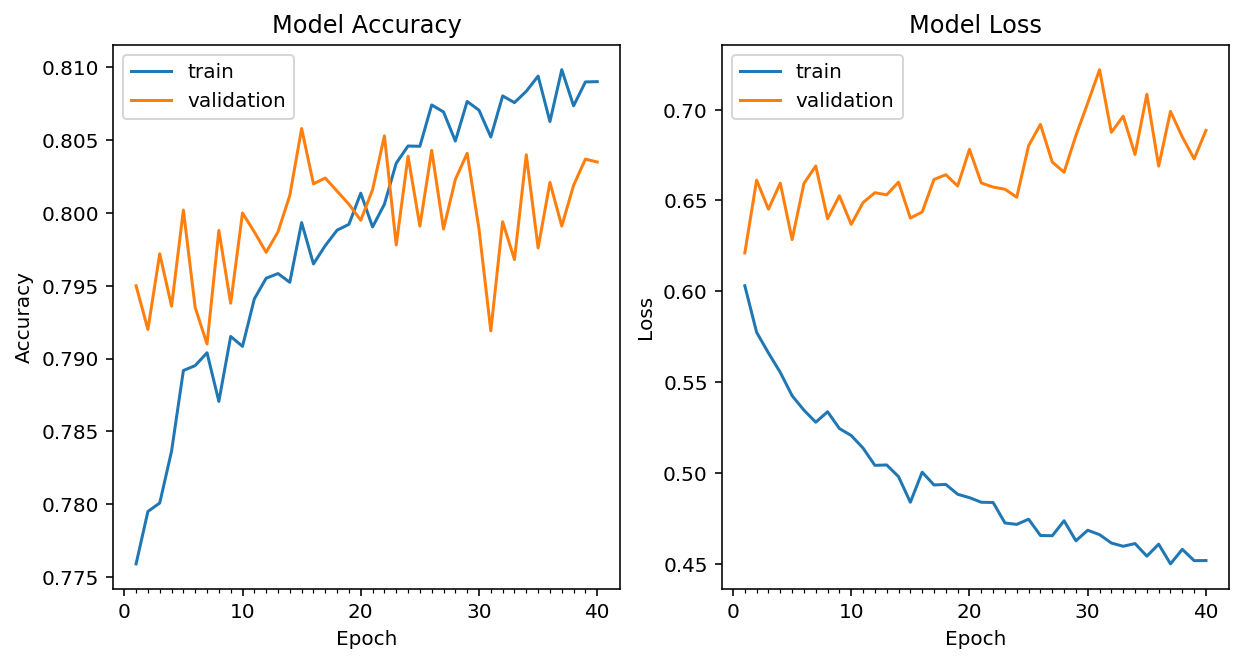

In [18]:
pctg_unlabeled=25
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/mixup/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})

# 50% Unlabeled Mixup

In [1]:
pctg_unlabeled=50
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/mixup/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})

NameError: ignored

# 75% Unlabeled Mixup

In [0]:
pctg_unlabeled=75
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/mixup/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})

# 25% Unlabeled Cutmix

In [0]:
pctg_unlabeled=25
path = f"{ROOT}/cifar/metrics/{pctg_unlabeled}%_unlabeled/cutmix/"
plot_metrics_and_graph(path, {'custom_loss': custom_loss})